# Simulating and Loading Data

Damuta provides two classes for input data: `DataSet` and `SignatureSet`. 

`DataSet` ensures that a counts dataframe and sample annotation can be easily aligned via matching on sample ids. 

`SignatureSet` provides some simple methods for summarizing and understanding mutational signatures, as well for extracing damage and misrepair signatures from COSMIC-format signatures. 

## Simulating Data 

We can simulate a dataset of mutation counts using the function `sim_parametric`. We will simulate `500` samples containing `10000` mutations each, with varying activities of `10` damage signatures, and `8` misrepair signatures. 

In [6]:
from damuta.sim import sim_parametric

counts, params = sim_parametric(S=500, N=10000, n_damage_sigs=10, n_misrepair_sigs=8, seed=1992)

print(counts.sum(1))
counts.head()

simulated_sample_0      10000
simulated_sample_1      10000
simulated_sample_2      10000
simulated_sample_3      10000
simulated_sample_4      10000
                        ...  
simulated_sample_495    10000
simulated_sample_496    10000
simulated_sample_497    10000
simulated_sample_498    10000
simulated_sample_499    10000
Length: 500, dtype: int64


,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
simulated_sample_0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
simulated_sample_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
simulated_sample_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
simulated_sample_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,456
simulated_sample_4,0,0,0,2,0,0,0,0,1,0,...,0,29,0,0,21,0,103,1,0,0


Next, lets make use of `DataSet` to organize our data for us. 

We will simulate some metadata annotate our 500 samples with. This is most applicable for pan-cancer data, and necessary when fitting Damuta's `HierarchicalTandemLda` model, but the annotation slot of the `DataSet` is also useful for holding clinical metadata about each sample. 

Note: Pan-cancer data is not required. All Damuta models can just as easily fit a dataset where all samples come from the same tissue type. 

The `DataSet` class at minimum acts as a container for a pandas DataFrame of mutation type counts. The metadata annotation is also be a pandas DataFrame, in [tidy format](https://en.wikipedia.org/wiki/Tidy_data) (ie. each row is a sample, each column is a feature). The DataFrame index of both the count data and annotation data is the sample id. 

In this example, we simulated the counts dataframe, but in principle any trinucleotide count data that can be loaded with `pd.read_csv` can be used.

In [7]:
import numpy as np
import pandas as pd
from damuta import DataSet, SignatureSet

# pick from 3 tissues 
tissues = np.array(["Breast-AdenoCA", "Kidney-RCC", "ColoRect-AdenoCA"])

# pick from primary or metastatic tumour
types = np.array(['primary', 'metastatic'])


# randomly assign tissue type to samples
annotation = pd.DataFrame.from_dict({"tissue_type": tissues[np.random.choice(3,500)],
                                     "tumour_type": types[np.random.choice(2,500)]
                                     })
annotation = annotation.set_index(counts.index)
annotation.head()

,tissue_type,tumour_type
simulated_sample_0,Breast-AdenoCA,primary
simulated_sample_1,Breast-AdenoCA,primary
simulated_sample_2,ColoRect-AdenoCA,primary
simulated_sample_3,ColoRect-AdenoCA,metastatic
simulated_sample_4,Kidney-RCC,metastatic


Pair the counts and metadata with the `DataSet` class.

In [8]:
simulated_data = DataSet(counts, annotation)
print(f"simulated_data contains {simulated_data.nsamples} samples")
print(simulated_data.ids[0:5])

simulated_data contains 500 samples
['simulated_sample_0', 'simulated_sample_1', 'simulated_sample_2', 'simulated_sample_3', 'simulated_sample_4']


## Loading signature data

Lastly, let's retrieve a set of mutational signatures from the [COSMIC database](https://cancer.sanger.ac.uk/signatures/).


In [9]:
signatures = pd.read_csv("https://cancer.sanger.ac.uk/signatures/documents/452/COSMIC_v3.2_SBS_GRCh37.txt", sep='\t', index_col=0 , header=0)

COSMIC = SignatureSet(signatures.T)
print(f"COSMIC contains {COSMIC.nsigs} signatures")

COSMIC contains 78 signatures


Every COSMIC mutational signature can be re-written as a product of a damage signautre and misrepair signautre. We'll visualize these with `plotly`. 

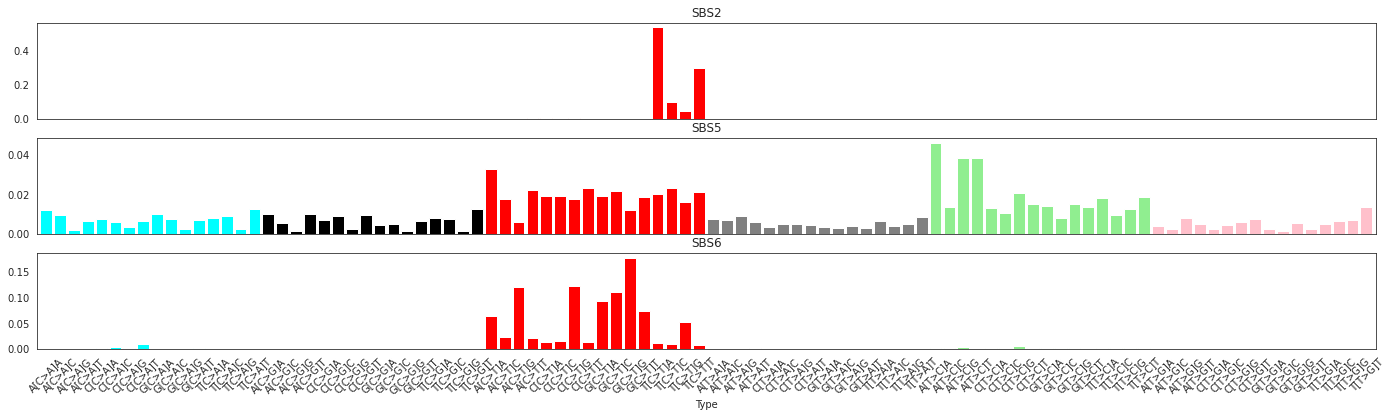

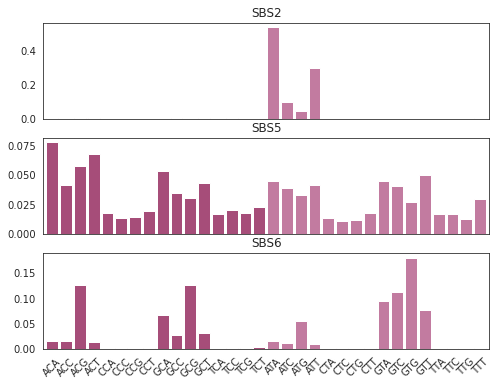

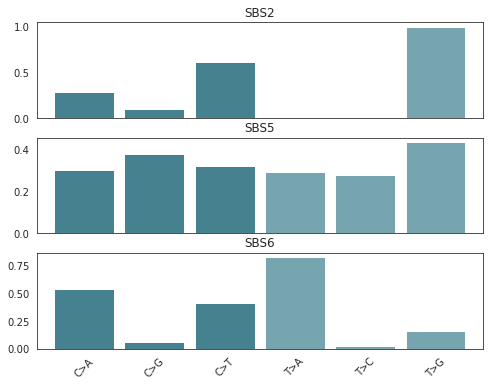

In [18]:
from matplotlib import rcParams
rcParams["figure.figsize"]=8,6
from damuta.plotting import plot_signatures

cosmic=plot_signatures(COSMIC.signatures.loc[["SBS2", "SBS5", "SBS6"]]).set_figwidth(24)
damage=plot_signatures(COSMIC.damage_signatures.loc[["SBS2", "SBS5", "SBS6"]])
misrepair=plot_signatures(COSMIC.misrepair_signatures.loc[["SBS2", "SBS5", "SBS6"]])


The COSMIC signautres are a high quality reference set, as can seen in their high degree of separation (low cosine similarity between different signatures)

In [24]:
COSMIC.summarize_separation()

,Signature separation,Damage signature separation,Misrepair signature separation
count,3003.000000,3003.000000,3003.000000
mean,0.188203,0.386702,0.687093
std,0.188601,0.240145,0.199465
min,0.000346,0.002237,0.029616
25%,0.047759,0.180305,0.560310
50%,0.118585,0.363235,0.721189
75%,0.276046,0.570838,0.844802
max,0.979184,0.980502,0.996766
